# Create dataset for DPO

## Goal

Create a dataset with the required format for DPO fine-tuning:

- https://huggingface.co/docs/trl/main/en/dpo_trainer#expected-dataset-format

The dataframe should have the following fields: prompt, chosen and rejected.

The evaluation of the MATH test dataset provides me with correct and incorrect answers. I could change the prompt at my will.

## Imports

In [1]:
import pandas as pd
import json as json
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random

from transformers import AutoTokenizer

plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (20, 5)
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

## Data loading

In [2]:
dataset = pd.read_csv('/mnt/hdd0/Kaggle/aimo/external_data/filtered_MATH_test_5.csv')
dataset.head()

,problem,level,type,solution,stage,source,n_boxed,answer,input_tokens,output_tokens,total_tokens,id
0,John computes the sum of the elements of each ...,Level 5,Algebra,"Among the two-element subsets of $\{1,2,3,4,5,...",test,MATH,1,105,43,94,137,5572
1,Rationalize the denominator: $\frac{1}{1 + \sq...,Level 5,Algebra,We begin by grouping terms in the denominator ...,test,MATH,1,12,75,405,480,5583
2,Given that $f(2)=5$ and $f^{-1}(x+4)=2f^{-1}(x...,Level 5,Algebra,Note that $f(2)=5$ implies $f^{-1}(5)=2$. Appl...,test,MATH,1,23,42,148,190,5584
3,Simplify $\frac{3}{\sqrt[5]{16}}+\frac{1}{\sqr...,Level 5,Algebra,Rationalizing each of the two fractions on its...,test,MATH,1,5,81,250,331,5600
4,Let $f$ be defined by \[f(x) = \left\{\n\begi...,Level 5,Algebra,The number $f^{-1}(0)$ is the value of $x$ suc...,test,MATH,1,0,89,744,833,5633


In [3]:
len(dataset)

580

In [4]:
with open('/mnt/hdd0/Kaggle/aimo/experiments/17_vllm/400_repetitions.json', 'r') as file:
    responses = json.load(file)
len(responses)

580

In [5]:
responses['0'][0]['prompt'][-50:]

'n solve the problem by writing a Python program.\n\n'

## Data filtering

I will use the following definition of good and bad responses:

- A good response is one where the text and code answer is the same and equal to the ground truth.
- A bad response is one where there is at least text answer and it is different to the ground truth.

In [6]:
good_responses = dict()
bad_responses = dict()

for idx, ground_truth in tqdm(enumerate(dataset['answer']), total=len(dataset)):
    good_responses[idx] = []
    bad_responses[idx] = []
    for result in responses[str(idx)]:
        if ground_truth == result['text_answer'] and ground_truth == result['code_answer']:
            good_responses[idx].append(result['response'])
        if ground_truth != result['text_answer'] and result['text_answer'] is not None:
            bad_responses[idx].append(result['response'])
    # remove repetitions
    good_responses[idx] = list(set(good_responses[idx]))
    bad_responses[idx] = list(set(bad_responses[idx]))

  0%|          | 0/580 [00:00<?, ?it/s]

Let's study the distribution of good and bad responses.

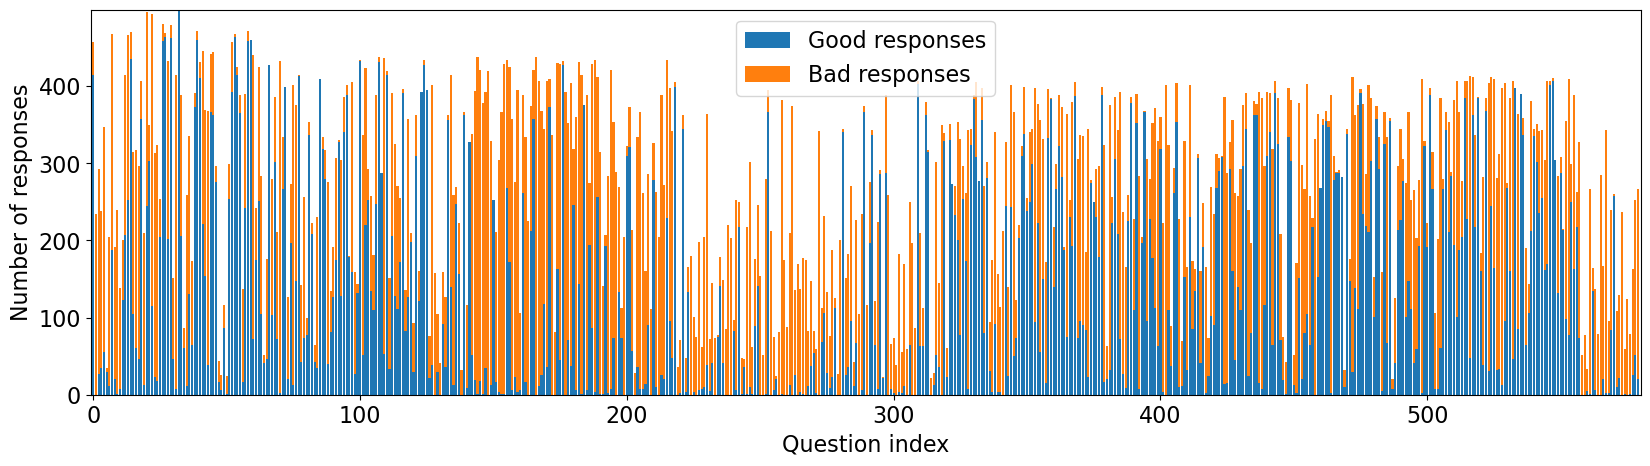

In [7]:
plt.bar(np.arange(580), [len(good_responses[idx]) for idx in range(580)], label='Good responses')
plt.bar(np.arange(580), [len(bad_responses[idx]) for idx in range(580)], label='Bad responses', bottom=[len(good_responses[idx]) for idx in range(580)])
plt.xlim(-1, 580)
plt.legend()
plt.xlabel('Question index')
plt.ylabel('Number of responses');

In [8]:
def show_random_responses(idx):
    print('Ground truth:', dataset['answer'][idx])
    print('Good response:')
    print(random.choice(good_responses[idx]))
    print('\n\nBad responses:')
    print(random.choice(bad_responses[idx]))

In [9]:
show_random_responses(200)

Ground truth: 40
Good response:
```python
from sympy import symbols, pi, solve, simplify

def volume_of_sphere():
    r = symbols('r')
    volume_cylinder = 60  # given
    # volume of cylinder = pi*r^2*h. Here, h = 2r (for a cylinder that circumscribes a sphere),
    # so volume of cylinder = pi*r^2*2r = 2*pi*r^3.
    # Setting this equal to the given volume of the cylinder gives us the value of r.
    r_value = solve(2*pi*r**3 - volume_cylinder, r)[0]

    # Now that we have r, we can find the volume of the sphere (4/3*pi*r^3).
    volume_sphere = simplify(4/3 * pi * r_value**3)

    return volume_sphere

result = volume_of_sphere()
print(result)
``````output
40.0000000000000
```
The volume of the sphere is $\boxed{40}$ cubic centimeters. The answer is: $40$


Bad responses:
```python
from sympy import symbols, solve, pi

def calculate_volume():
    # r is the radius of the cylinder
    r = symbols('r')

    # The volume of a cylinder is πr²h, and here h = 2r (the diameter of the cyl

This looks correct.

Let's also gather the prompts.

In [10]:
max_prompt_length = 300
tokenizer = AutoTokenizer.from_pretrained('/home/gbarbadillo/data/deepseekmath')
unique_prompts = dict()
for idx in range(580):
    results = responses[str(idx)]
    unique_prompts[idx] = list(set([result['prompt'] for result in results]))
    unique_prompts[idx] = [prompt for prompt in unique_prompts[idx] if len(tokenizer.tokenize(prompt)) < max_prompt_length]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Creating dataset for DPO

At this point I have good and bad responses. I have to create pairs of them.

For this first version of the dataset I'm going to avoid repetitions. But on future version I could create many more pairs.

In [11]:
chosen, rejected, prompt, problem_idx = [], [], [], []
n_pairs = 50
for idx in range(580):
    if unique_prompts[idx] and good_responses[idx] and bad_responses[idx]:
        chosen.extend(np.random.choice(good_responses[idx], n_pairs, replace=True).tolist())
        rejected.extend(np.random.choice(bad_responses[idx], n_pairs, replace=True).tolist())
        prompt.extend(np.random.choice(unique_prompts[idx], n_pairs, replace=True).tolist())
        problem_idx.extend([idx] * n_pairs)
assert len(chosen) == len(rejected) == len(problem_idx)
len(chosen)

25450

Now let's gather prompts for the problems, let's reuse the results for that.

(array([  0.,   0.,   0.,   0.,   0., 509.,   0.,   0.,   0.,   0.]),
 array([49.5, 49.6, 49.7, 49.8, 49.9, 50. , 50.1, 50.2, 50.3, 50.4, 50.5]),
 <BarContainer object of 10 artists>)

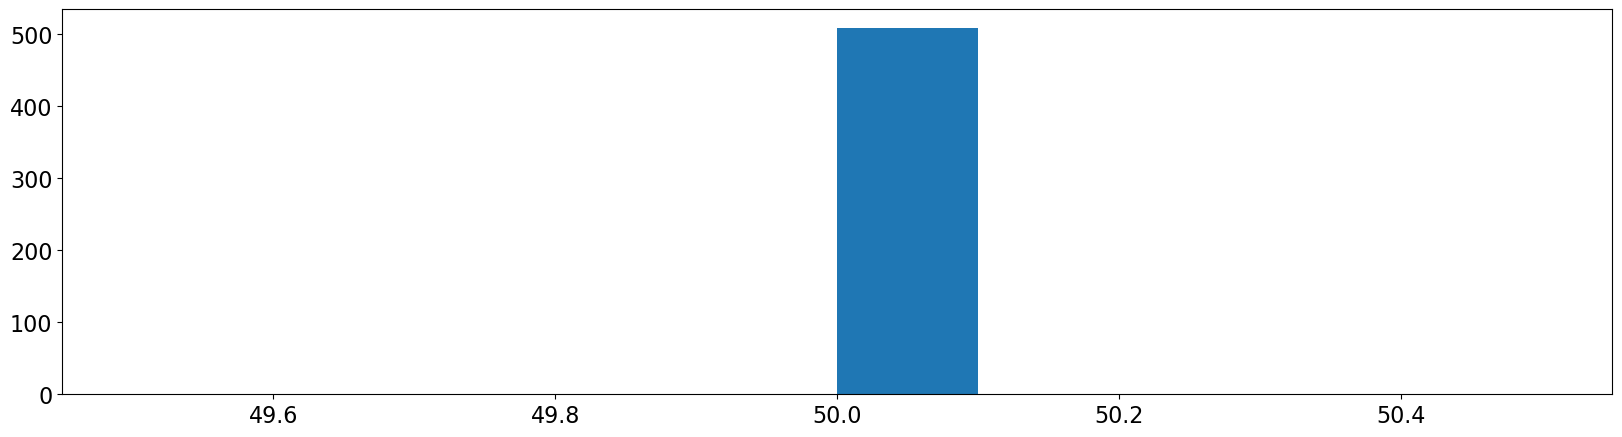

In [12]:
plt.hist(np.unique(problem_idx, return_counts=True)[1])

Many problems have a lot of good and bad responses.

In [13]:
df = pd.DataFrame({'prompt': prompt, 'chosen': chosen, 'rejected': rejected, 'problem_idx': problem_idx})
df.head()

,prompt,chosen,rejected,problem_idx
0,Below is a math problem you are to solve (non ...,```python\nfrom itertools import combinations\...,"```python\nfrom sympy import binomial, Rationa...",0
1,\nUser: John computes the sum of the elements ...,```python\nfrom itertools import combinations\...,"```python\nfrom sympy import binomial, summati...",0
2,Below is a math problem you are to solve (non ...,```python\nfrom itertools import combinations\...,"```python\nfrom sympy import binomial, Rationa...",0
3,You are an expert mathematical programmer. Sol...,```python\nfrom itertools import combinations\...,```python\nfrom sympy import *\n\ndef sum_of_s...,0
4,User: John computes the sum of the elements of...,```python\nfrom itertools import combinations\...,"```python\nfrom sympy import binomial, summati...",0


Finally let's remove the python codeblock start from the response to the prompt.

In [14]:
print(df['chosen'].apply(lambda x: x.startswith('```python\n')).mean())
print(df['rejected'].apply(lambda x: x.startswith('```python\n')).mean())
df['prompt'].apply(lambda x: x.endswith('```python')).mean()

1.0
1.0


0.001100196463654224

In [15]:
df['chosen'] = df['chosen'].apply(lambda x: x[10:])
df['rejected'] = df['rejected'].apply(lambda x: x[10:])

In [16]:
df['prompt'] = df['prompt'].apply(lambda x: x + '\n' if x.endswith('```python') else x + '```python\n').values

In [17]:
print(df['chosen'].apply(lambda x: x.startswith('```python\n')).mean())
print(df['rejected'].apply(lambda x: x.startswith('```python\n')).mean())
df['prompt'].apply(lambda x: x.endswith('```python\n')).mean()

0.0
0.0


1.0

Let's count the max lenght and max prompt length.

In [18]:
# df['max_prompt_length'] = df['prompt'].apply(lambda x: len(tokenizer.tokenize(x)))
# df['chosen_length'] = df['chosen'].apply(lambda x: len(tokenizer.tokenize(x)))
# df['rejected_length'] = df['rejected'].apply(lambda x: len(tokenizer.tokenize(x)))

# print(f'Max prompt length: {df["max_prompt_length"].max()}')
# print(f'Max length: {df["max_prompt_length"].max() + max(df["chosen_length"].max(), df["rejected_length"].max())}')

- Max prompt length: 299
- Max length: 937

In [19]:
len(df.problem_idx.unique())

509

In [20]:
df.to_csv('/mnt/hdd0/Kaggle/aimo/external_data/dpo/v2.csv', index=False)
df.head()

,prompt,chosen,rejected,problem_idx
0,Below is a math problem you are to solve (non ...,from itertools import combinations\n\ndef sum_...,"from sympy import binomial, Rational, simplify...",0
1,\nUser: John computes the sum of the elements ...,from itertools import combinations\n\ndef sum_...,"from sympy import binomial, summation, symbols...",0
2,Below is a math problem you are to solve (non ...,from itertools import combinations\n\ndef sum_...,"from sympy import binomial, Rational, simplify...",0
3,You are an expert mathematical programmer. Sol...,from itertools import combinations\n\ndef sum_...,from sympy import *\n\ndef sum_of_subset_sums(...,0
4,User: John computes the sum of the elements of...,from itertools import combinations\n\ndef sum_...,"from sympy import binomial, summation, symbols...",0
